In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [2]:
roll = 102317171

a = 0.05*(roll % 7)
b = 0.3*(roll % 5 + 1)
print(f"Roll Number is: {roll}")
print(f"value of a = {a}")
print(f"value of b = {b}")

Roll Number is: 102317171
value of a = 0.25
value of b = 0.6


In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "shrutibhargava94/india-air-quality-data",
    "data.csv",
    pandas_kwargs={
        "encoding": "ISO-8859-1",
        "low_memory": False
    }
)

print(df.head())

/tmp/ipython-input-3372009676.py:4: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 5.22M/5.22M [00:00<00:00, 114MB/s]

Extracting zip of data.csv...


  stn_code       sampling_date           state   location agency  \
0      150  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1      151  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2      152  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3      150     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4      151     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN   

  location_monitoring_station  pm2_5        date  
0                         NaN    NaN  1990-02-01  
1                         NaN    NaN  1990-02-01  
2                         NaN    NaN  1990-02-01  
3       

In [4]:
if "no2" not in df.columns:
    raise KeyError("CSV does not contain 'no2' column.")

x = df["no2"].dropna().astype(float).values
if x.size == 0:
    raise ValueError("No valid NO2 values found.")

In [5]:
z = x + a*np.sin(b*x)

In [6]:
def neg_ll(p, z):
    lam, mu = p
    if lam <= 0:
        return 1e12
    c = np.sqrt(lam / np.pi)
    return -np.sum(np.log(c) - lam*(z - mu)**2)

In [7]:
res = minimize(
    neg_ll,
    [1/(2*np.var(z)), np.mean(z)],
    args=(z,),
    method="L-BFGS-B",
    bounds=[(1e-6, None), (None, None)]
)

lam, mu = res.x
c = np.sqrt(lam / np.pi)

print(f"c = {c:.6f}, lambda = {lam:.6f}, mu = {mu:.6f}")

c = 0.021562, lambda = 0.001461, mu = 25.812662


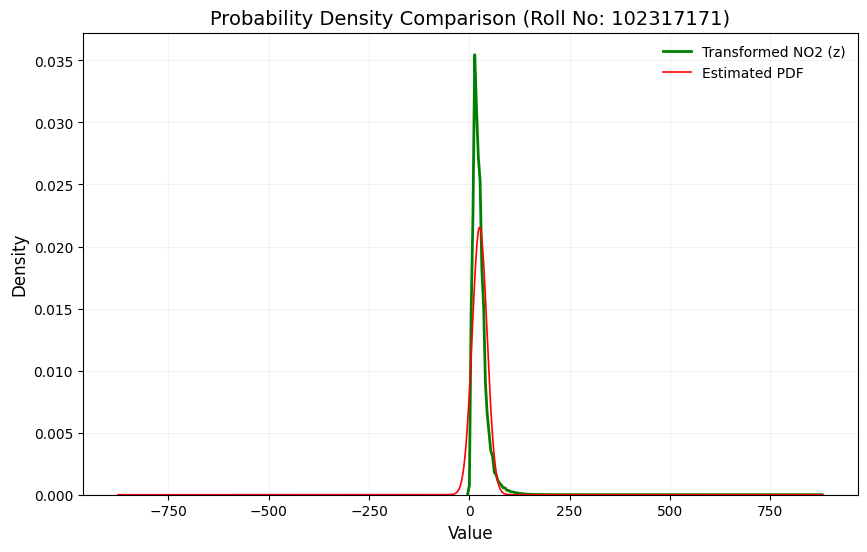

In [8]:
plt.figure(figsize=(10, 6))
sns.kdeplot(z, color='green', label='Transformed NO2 (z)', fill=False, lw=2)
z_range = np.linspace(-max(z), max(z) + 5, 1000)
p_hat = c * np.exp(-lam * (z_range - mu)**2)
plt.plot(z_range, p_hat, color='red', lw=1.2, label=r'Estimated PDF')
plt.title(f'Probability Density Comparison (Roll No: {roll})', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(frameon=False)
plt.grid(True, alpha=0.15)
plt.show()